In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim

import os
import matplotlib.pyplot as plt
import pickle
import gym
import gym_ur5
import random
import numpy as np
from collections import deque

In [2]:
def mini_batch_train(env, agent, max_episodes, max_steps, batch_size):
    episode_rewards = []

    for episode in range(max_episodes):
        state = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            # env.render()
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.push(state, action, reward, next_state, done)
            episode_reward += reward

            if len(agent.replay_buffer) > batch_size:
                agent.update(batch_size)   

            if done or step == max_steps-1:
                episode_rewards.append(episode_reward)
                print("Episode " + str(episode) + ": " + str(episode_reward))
                break

            state = next_state

    return episode_rewards

In [3]:
class BasicBuffer:

    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

            return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)

    def __len__(self):
        return len(self.buffer)

In [4]:
# Ornstein-Ulhenbeck Noise
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

In [5]:
class Critic(nn.Module):

    def __init__(self, obs_dim, action_dim):
        super(Critic, self).__init__()

        self.obs_dim = obs_dim
        self.action_dim = action_dim

        self.linear1 = nn.Linear(self.obs_dim, 1024)
        self.linear2 = nn.Linear(1024 + self.action_dim, 512)
        self.linear3 = nn.Linear(512, 300)
        self.linear4 = nn.Linear(300, 1)

    def forward(self, x, a):
        x = F.relu(self.linear1(x))
        xa_cat = torch.cat([x,a], 1)
        xa = F.relu(self.linear2(xa_cat))
        xa = F.relu(self.linear3(xa))
        qval = self.linear4(xa)

        return qval

class Actor(nn.Module):

    def __init__(self, obs_dim, action_dim):
        super(Actor, self).__init__()

        self.obs_dim = obs_dim
        self.action_dim = action_dim

        self.linear1 = nn.Linear(self.obs_dim, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, self.action_dim)

    def forward(self, obs):
        x = F.relu(self.linear1(obs))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

In [6]:
class DDPGAgent:
    
    def __init__(self, env, gamma, tau, buffer_maxlen, critic_learning_rate, actor_learning_rate):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        
        # hyperparameters
        self.env = env
        self.gamma = gamma
        self.tau = tau
        
        self.critic_lr = critic_learning_rate
        self.actor_lr   = actor_learning_rate
        
        # initialize actor and critic networks
        self.critic = Critic(self.obs_dim, self.action_dim).to(self.device)
        self.critic_target = Critic(self.obs_dim, self.action_dim).to(self.device)
        
        self.actor = Actor(self.obs_dim, self.action_dim).to(self.device)
        self.actor_target = Actor(self.obs_dim, self.action_dim).to(self.device)
    
        # Copy critic target parameters
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # optimizers
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
    
        self.replay_buffer = BasicBuffer(buffer_maxlen)        
        self.noise = OUNoise(self.env.action_space)
        
    def get_action(self, obs):
        state = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
        action = self.actor.forward(state)
        action = action.squeeze(0).cpu().detach().numpy()

        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.replay_buffer.sample(batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, masks = self.replay_buffer.sample(batch_size)
        state_batch = torch.FloatTensor(state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        masks = torch.FloatTensor(masks).to(self.device)
   
        curr_Q = self.critic.forward(state_batch, action_batch)
        next_actions = self.actor_target.forward(next_state_batch)
        next_Q = self.critic_target.forward(next_state_batch, next_actions.detach())
        expected_Q = reward_batch + self.gamma * next_Q
        
        # update critic
        q_loss = F.mse_loss(curr_Q, expected_Q.detach())

        self.critic_optimizer.zero_grad()
        q_loss.backward() 
        self.critic_optimizer.step()

        # update actor
        policy_loss = -self.critic.forward(state_batch, self.actor.forward(state_batch)).mean()
        
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
            
    
    def save_agent(self, path='.'):
        if not os.path.exists(path):
            os.mkdir(path)
        model_config = {
            'gamma':self.gamma,
            'tau':self.tau,
            'critic_lr':self.critic_lr,
            'actor_lr':self.actor_lr
        }
        
        with open(path+'/model_config.pkl','wb') as f:
            pickle.dump(model_config, f)
        torch.save(self.actor, path+'/actor.pt')
        torch.save(self.actor_target, path+'/actor_target.pt')
        torch.save(self.critic, path+'/critic.pt')
        torch.save(self.critic_target, path+'/critic_target.pt')
        
    def load_agent(self, path='.'):
        with open(path+'/model_config.pkl','rb') as f:
            model_config = pickle.load(f)
            
        self.gamma = model_config['gamma']
        self.tau   = model_config['tau']
        self.critic_lr = model_config['critic_lr']
        self.actor_lr  = model_config['actor_lr']
            
        torch.save(self.actor, path+'/actor.pt')
        torch.save(self.actor_target, path+'/actor_target.pt')
        torch.save(self.critic, path+'/critic.pt')
        torch.save(self.critic_target, path+'/critic_target.pt')
        

In [7]:
env = gym.make('ur5-v0')

max_episodes = 10
max_steps = 500
batch_size = 32

gamma = 0.99
tau = 1e-2
buffer_maxlen = 100000
critic_lr = 1e-3
actor_lr = 1e-3

model_config = {
    'max_episodes':max_episodes,
    'max_steps':max_steps,
    'batch_size':batch_size,
    'gamma':gamma,
    'tau':tau,
    'critic_lr':critic_lr,
    'actor_lr':actor_lr
}

agent = DDPGAgent(env, gamma, tau, buffer_maxlen, critic_lr, actor_lr)
episode_rewards = mini_batch_train(env, agent, max_episodes, max_steps, batch_size)

Episode 0: -47.089001933541745
Episode 1: -50.25217513689178
Episode 2: -43.435369457468695
Episode 3: -41.434723878411155
Episode 4: -33.71517670679219
Episode 5: -46.21118578905957
Episode 6: -54.873335794876134
Episode 7: -59.18273258413437
Episode 8: -54.08611750097534
Episode 9: -55.91473320085195


In [8]:
episode_rewards = mini_batch_train(env, agent, 100, max_steps, batch_size)

Episode 0: -51.48007067404924
Episode 1: -52.35003493277284
Episode 2: -46.25957789595462
Episode 3: -58.098230108907046
Episode 4: -40.43745269155341
Episode 5: -43.24423214161571
Episode 6: -44.71613454728344
Episode 7: -41.276483206873564
Episode 8: -44.86552672878979
Episode 9: -43.00685293393856
Episode 10: -40.68305254910727
Episode 11: -44.081933265395115
Episode 12: -42.73548463785634
Episode 13: -41.85758705190965
Episode 14: -43.70157380358982
Episode 15: -42.501910951719445
Episode 16: -42.337444903792964
Episode 17: -47.222687218616635
Episode 18: -65.43442936028151
Episode 19: -48.29900288114626
Episode 20: -54.11221873982029
Episode 21: -62.75435372100404
Episode 22: -52.103316489256954
Episode 23: -49.886320636972435
Episode 24: -51.64571271637849
Episode 25: -48.544690485103075
Episode 26: -56.89072491163277
Episode 27: -57.85589460271482
Episode 28: -47.17450049939108
Episode 29: -50.00440534217989
Episode 30: -53.09397739828448
Episode 31: -58.98820060856995
Episode 3

Text(0.5, 1.0, 'average distance')

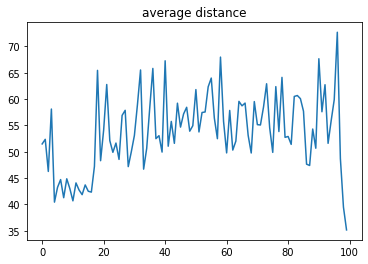

In [9]:
plt.plot(-np.array(episode_rewards))
plt.title('average distance')

In [10]:
def play(env, agent, max_episodes, max_steps, batch_size):
    episode_rewards = []

    for episode in range(max_episodes):
        state = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            env.render()
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            # agent.replay_buffer.push(state, action, reward, next_state, done)
            episode_reward += reward

            # if len(agent.replay_buffer) > batch_size:
            #     agent.update(batch_size)   

            if done or step == max_steps-1:
                episode_rewards.append(episode_reward)
                print("Episode " + str(episode) + ": " + str(episode_reward))
                break

            state = next_state

    return episode_rewards

In [11]:
inferece_rewards = play(env, agent, 10, max_steps, batch_size)

Episode 0: -43.279801426764436
Episode 1: -49.11933829482114
Episode 2: -54.70719574376188
Episode 3: -45.160790750608506
Episode 4: -44.82008603428957
Episode 5: -46.81823617469543
Episode 6: -45.13686301720994
Episode 7: -43.21331554375207
Episode 8: -43.09240323337849
Episode 9: -50.38047850368661


Text(0.5, 1.0, 'inference average distance')

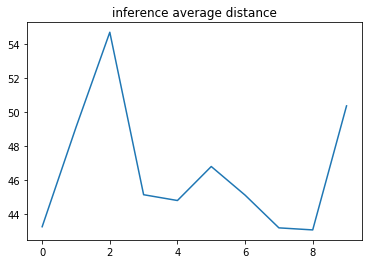

In [12]:
plt.plot(-np.array(inferece_rewards))
plt.title('inference average distance')

In [13]:
env.close()